
Please head to the https://drive.google.com/drive/folders/14LKnmDwWf1rxjUwgH--nPMgwAXOBhadR?usp=sharing

Download the dataset "CatRabbit.zip" and unzip the content in the zip file and upload it to google drive

Then launch a Google Colab Notebook (default with TensorFlow module)

Mount the google drive after enter the Colab environment

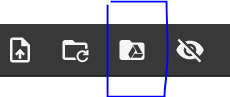



Importing headers

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.layers import *
from keras.models import *
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
import time
import os, shutil

Verify the data Source is usable on the Google Drive.<br>
Change the path according to your google drive setting. <br>
The dataset need to be downloaded and mounted from google drive first <br>
After mounting, the dataset file should be something like: <br> "/content/drive/(the path of dataset on your google drive path)"

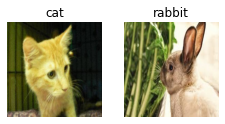

In [2]:
train_src = "/content/drive/MyDrive/GrpProjectDataSet/CatRabbit/train-cat-rabbit"
validation_src = "/content/drive/MyDrive/GrpProjectDataSet/CatRabbit/val-cat-rabbit"
image_categories = ["cat","rabbit"]

plt.figure(figsize=(8,8))
for i, category in enumerate(image_categories):
  image_folder_path = train_src + '/' + category
  folderimages = os.listdir(image_folder_path)
  img = image.load_img(image_folder_path + '/' + folderimages[0])
  img_arr = image.img_to_array(img)/255.0
  plt.subplot(4,4,i+1)
  plt.imshow(img_arr)
  plt.title(category)
  plt.axis('off')
plt.show()


Building CNN (Convolutional Neural Network)

In [3]:
#Start time measurement
start_time = time.time()

# Create 2 different dataframe
# target_size will affect the image size after resizing
# batch_size will affect the amount of input per once reading, smaller will result in a more accurate result
# class_model will determine the type of label returned, currently return 2D one-hot encoded labels
# classes will determine the content of the label returned, same as image_categories ["cat","rabbit"]
train_gen = ImageDataGenerator(rescale = 1.0/255.0)
tra_img_generator = train_gen.flow_from_directory(
    train_src,(224,224),batch_size = 32, class_mode='categorical', classes=["cat", "rabbit"])

val_gen = ImageDataGenerator(rescale = 1.0/255.0)
val_img_generator = train_gen.flow_from_directory(
    validation_src,(224,224),batch_size = 32, class_mode='categorical', classes=["cat", "rabbit"])

#tes_gen = ImageDataGenerator(rescale = 1.0/255.0)
#tes_img_generator = train_gen.flow_from_directory(
#    directory = test_src,target_size = (224,224),batch_size = 32, class_mode='categorical', classes=image_categories)

#Print out the dataframe structure 
print(tra_img_generator.class_indices)

Found 1595 images belonging to 2 classes.
Found 414 images belonging to 2 classes.
{'cat': 0, 'rabbit': 1}


For the parameters in the Conv2D function:<br>
--------------------<br>
filter will affect the amount of Convolution kernel, which will impacting the output dimension <br>
For example, the following input_shape [224,224,3] will be expanded into [224,224, 32] <br>
--------------------<br>
kernel_size will affect the size (height and width) of each Convolution kernel
Larger kernel size means increasing the total number of parameters and results in higher complexity. <br>
--------------------<br>
strides will affect how much convolution kernel(s) is(are) shifted every time <br>
Large strides will shrink the dimension of input block <br>
If the strides equals to, the dimension of input block will be divided by 2, 3 will divided by 3, and so forth<br>
--------------------<br>
padding will affect how the model react with when a kernel window exceeds the image boundaries<br>
(3 options: same, valid and casual)<br>
Same: Pad with Zero, Valid: give up that kernel result, casual: ignore the exceeding part<br>
--------------------<br>
activation will determine with activation function used<br>
Commonly used: softmax, sigmoid, Relu, tanh<br>
softmax: returned value between 0 to 1<br>
sigmoid: returned value is either 0 or 1 (small fractions may return between 0 to 1)<br>
Relu: returned value between 0 to infinite positive<br>
tanh: similar to sigmoid but returned either -1 to 1 (small fractions may return between -1 to 1)<br>
--------------------<br>
<br><br><br>

For the parameters in the MaxPooling2D function:<br>
--------------------<br>
pool_size will affect the size of the pooling window<br>
default is 2 by 2<br>
--------------------<br>
strider will affect the far will the pooling window move per step<br>
default is None, will make step size the same as the pooling window<br>
--------------------<br>
padding act similarly to the one in Conv2D<br>
there are only 'valid' and 'same' option<br>
--------------------<br>
data_format will affect the order of the input dimension<br>
default is channels_last (batch, height, width, channels), another option is channels_first(batch, channels, height, width)<br>

In [4]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=[224, 224, 3]))
model.add(MaxPooling2D(2, ))
model.add(Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(2))

In [5]:
# Flatten the feature map
model.add(Flatten())

# Add the fully connected layers

# units will change the dimension of the output space
# activation: similar to the activation in Conv2D
model.add(Dense(units = 128, activation='relu'))

# rate control the amount of input unit to drop, in this case 25%
model.add(Dropout(rate = 0.25))
model.add(Dense(units = 128, activation='relu'))
model.add(Dense(units = 2, activation='softmax'))

# optimizer control the method for finding the best solution on the model
# common options are Adam, RMSprop, Adadelta
# More options can be found on https://keras.io/api/optimizers/

# loss function is used to measure how far an estimated value is from its true value
# common options are mean_squared_error, categorical_crossentropy, huber_loss, sparse_categorical_crossentropy and hinge
# More options can be found on https://keras.io/api/losses/

# metric is used to judge the performance for the model
# the most common option is accuracy (directly compare the predicted value and actual value)
# More options can be found on https://keras.io/api/metrics/
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=["accuracy"])

For the parameters in the fit function:<br>
--------------------<br>
tra_img_generator represents the training data source, DO NOT CHANGE IT (or the model will not work)<br>
epochs represents how many iteration over the entire dataset. <br>
Only accept integer <br>
--------------------<br>
verbose represent whether the information for each epoch needed to be recorded. <br>
3 options: 
0 (not recording)<br>
1 (record the loss, accuracy, validation loss and validation accuracy, and progress bar)<br>
2 (same as 1 but without progress bar) <br>
--------------------<br>
validation_data represents the training data source, DO NOT CHANGE IT (or the model will not work)<br>
--------------------<br>
steps_per_epoch represents amount of batches of samples to train. <br>
Only accept integer<br>
--------------------<br>
validation_steps represents the amount of batches of samples to draw before stopping during validation <br>
Only accept integer <br>
--------------------<br>
Callback will contain specified action performed during the training <br>
EarlyStopping is used here, meaning the training process may stop early.<br>
The parameters in the EarlyStopping is "monitor", "mode" and "patient" <br>
monitor means the referencing value, in this case the "validation loss"<br>
mode means the referencing value varing direction, auto is used here <br>
patience means that if the model does not make any major improvement in certain epochs, the training will stop<br>

Example:<br>
monitor="val_loss", mode='auto', patience=3 are set. <br>
The referencing value is "validation loss", the training process will wait for 3 epochs, the mode is auto <br>
The training will stop when the validation loss has stopped decreasing for 3 consecutive epochs <br>

Epoch 1/15
46/46 [==============================] - 125s 3s/step - loss: 0.0123 - accuracy: 0.9952 - val_loss: 1.2987 - val_accuracy: 0.7812
Epoch 2/15
46/46 [==============================] - 113s 2s/step - loss: 0.0296 - accuracy: 0.9905 - val_loss: 1.2195 - val_accuracy: 0.7674
Epoch 3/15
46/46 [==============================] - 113s 2s/step - loss: 0.0269 - accuracy: 0.9911 - val_loss: 1.2058 - val_accuracy: 0.7500
Epoch 4/15
46/46 [==============================] - 112s 2s/step - loss: 0.0382 - accuracy: 0.9905 - val_loss: 1.2085 - val_accuracy: 0.7778
Epoch 5/15
46/46 [==============================] - 112s 2s/step - loss: 0.0269 - accuracy: 0.9911 - val_loss: 1.7628 - val_accuracy: 0.7708
Epoch 6/15
46/46 [==============================] - 112s 2s/step - loss: 0.0325 - accuracy: 0.9870 - val_loss: 1.6927 - val_accuracy: 0.7118
Epoch 7/15
46/46 [==============================] - 112s 2s/step - loss: 0.0224 - accuracy: 0.9932 - val_loss: 1.8016 - val_accuracy: 0.7361
Epoch 8/15
46

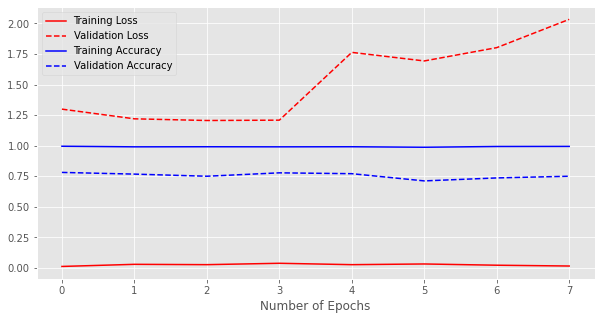

The seconds required to train this CNN model is:  2062.7762937545776


In [8]:
hist = model.fit(tra_img_generator, 
                 epochs=15, 
                 verbose=1, 
                 validation_data=val_img_generator, 
                 steps_per_epoch = 1500//32, 
                 validation_steps = 300//32, 
                 callbacks=[EarlyStopping(monitor="val_loss", mode='auto', patience=5)])

processingTime = time.time() - start_time

# Performance evaluation statistic
h = hist.history
plt.style.use('ggplot')
plt.figure(figsize=(10, 5))
plt.plot(h['loss'], c='red', label='Training Loss')
plt.plot(h['val_loss'], c='red', linestyle='--', label='Validation Loss')
plt.plot(h['accuracy'], c='blue', label='Training Accuracy')
plt.plot(h['val_accuracy'], c='blue', linestyle='--', label='Validation Accuracy')
plt.xlabel("Number of Epochs")
plt.legend(loc='best')
plt.show()
print("The seconds required to train this CNN model is: ", processingTime)


The following is the prediction

The seconds required to predict is:  3.1195485591888428


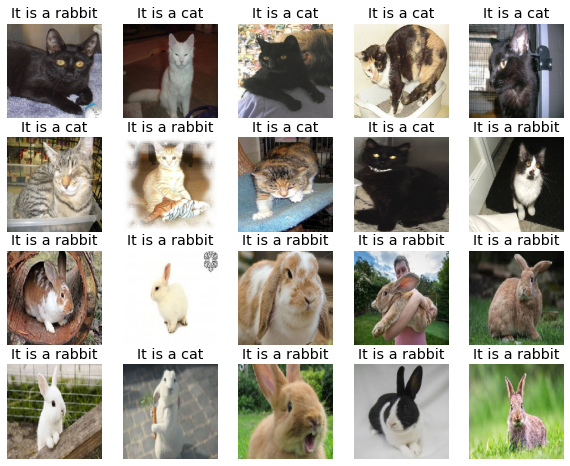

In [9]:
import glob
fig = plt.figure(figsize=(10, 8))
rows = 4
columns = 5
count = 1

print("The following is the prediction\n")

predict_start_time = time.time()
for i in glob.glob('/content/drive/MyDrive/GrpProjectDataSet/CatRabbit/test-images/*.jpg') :
    img = image.load_img(i, target_size=(224, 224))
    x = np.expand_dims(image.img_to_array(img), axis=0)

    images = np.vstack([x])
    classes= model.predict(x)
    classes_x=np.argmax(classes,axis=1)
    if classes_x == 1:
        fig.add_subplot(rows, columns, count)
        plt.imshow(img)
        plt.axis('off')
        plt.title("It is a rabbit")
        count = count + 1
    
    if classes_x == 0:
        fig.add_subplot(rows, columns, count)
        plt.imshow(img)
        plt.axis('off')
        plt.title("It is a cat")
        count = count + 1

PredictTime = time.time() - predict_start_time
print("The seconds required to predict is: ", PredictTime)